# Import

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install pyensembl
from pyensembl import EnsemblRelease

# Load Files

In [2]:
# Load File
DATA_PATH = Path('../../Data/')
metadata = pd.read_csv(Path(DATA_PATH, 'Original/TCGA.HNSC.metadata.txt'), sep = '\t').fillna("NaN")
mutations = pd.read_csv(Path(DATA_PATH, 'Original/TCGA.HNSC.mutations.txt'), sep = '\t').fillna("NaN")

# Functions

In [24]:
codon_to_aa = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

In [3]:
def classify_dn_ds(vclass):
    if vclass == 'Silent':
        return 'synonymous'
    else:
        return 'nonsynonymous'

In [4]:
def get_substitution(ref, alt):
    valid_bases = {'A', 'C', 'G', 'T'}
    if ref not in valid_bases or alt not in valid_bases:
        return None

    if ref in ['C', 'T']:
        return ref + "->" + alt
    else:
        # Reverse complement both ref and alt
        complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        norm_ref = complement[ref]
        norm_alt = complement[alt]
        return norm_ref + "->" + norm_alt

In [5]:
def dn_ds_ratio(subset):
    n_dN = (subset['_dn_ds_mutation_type'] == 'nonsynonymous').sum()
    n_dS = (subset['_dn_ds_mutation_type'] == 'synonymous').sum()
    if n_dS == 0:
        ratio = (n_dN + 1) / (n_dS + 1)  # add pseudocount
    else:
        ratio = n_dN/n_dS
    return ratio 

In [33]:
def simulate_gene_mutations(cds_seq, mutation_rate_dict, codon_to_aa):
    results = []
    codons = [cds_seq[i:i+3] for i in range(0, len(cds_seq), 3)]

    for codon_idx, codon in enumerate(codons):
        if len(codon) < 3 or codon not in codon_to_aa:
            continue  # skip incomplete or invalid codons

        for pos in range(3):  # position within codon
            ref_base = codon[pos]

            for alt_base in ['A', 'C', 'G', 'T']:
                if alt_base == ref_base:
                    continue

                # Mutate codon
                mutated = list(codon)
                mutated[pos] = alt_base
                mutated_codon = ''.join(mutated)

                if mutated_codon not in codon_to_aa:
                    continue  # skip invalid codons

                # Determine mutation type
                original_aa = codon_to_aa[codon]
                mutated_aa = codon_to_aa[mutated_codon]
                mutation_type = 'synonymous' if original_aa == mutated_aa else 'nonsynonymous'

                # Get center position in CDS
                genome_pos = codon_idx * 3 + pos
                if genome_pos < 1 or genome_pos >= len(cds_seq) - 1:
                    continue  # skip edges

                # Get trinucleotide context (5' and 3' bases)
                context = cds_seq[genome_pos - 1] + "_" + cds_seq[genome_pos + 1]
                substitution = get_substitution(ref_base, alt_base)

                # Get mutation rate
                mutation_prob = mutation_rate_dict.get((context, substitution), 0.0)

                results.append({
                    'codon_index': codon_idx,
                    'codon': codon,
                    'mutated_codon': mutated_codon,
                    'ref_base': ref_base,
                    'alt_base': alt_base,
                    'position_in_codon': pos,
                    'context': context,
                    'substitution': substitution,
                    'mutation_type': mutation_type,
                    'mutation_probability': mutation_prob
                })

    return results

In [36]:
grouped

,_16_type_context,_substitution,count,mutation_rate
0,A_A,C->A,972,0.152734
1,A_A,C->G,2242,0.352294
2,A_A,C->T,2140,0.336266
3,A_A,T->A,216,0.033941
4,A_A,T->C,659,0.103551
...,...,...,...,...
91,T_T,C->G,2373,0.360803
92,T_T,C->T,2202,0.334803
93,T_T,T->A,236,0.035883
94,T_T,T->C,599,0.091075


# Preprocessing
modified from Harrison's code

In [6]:
# 1. filter to pass: kept high-quality mutations
mutations = mutations[mutations['FILTER'] == 'PASS']

# 2. remove deprecated vairant callers and missing callers
# from mutations['CALLERS'], remove str matching 'RADIA' and 'SOMATICSNIPER'
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='*', value='')
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='RADIA', value='')
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='SOMATICSNIPER', value='')
# in mutations['CALLERS'], if 2 '|' are next to each other, replace with ''
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='\\|\\|', value='', regex=True)
# count the number of '|' in mutations['CALLERS'] and store in a new column 'CALLERS_COUNT_ADJUSTED'
mutations['CALLERS_COUNT_ADJUSTED'] = mutations['CALLERS'].str.count('\\|')

# 3. Filter to consensus mutations
mutations = mutations[mutations['CALLERS_COUNT_ADJUSTED'] > 1]

# 4. Filter by n_depth >=10
mutations = mutations[mutations['n_depth'] >= 10] 

# 5. Filter by hypermutators > 1000 mutations per patient
# Identify patients with >1000 mutations
hypermutators = mutations['patient_id'].value_counts()
hypermutators = hypermutators[hypermutators > 1000].index
# Remove those patients
mutations = mutations[~mutations['patient_id'].isin(hypermutators)]


In [7]:
# !!!!! additional step !!!!!
# 6. Only SNP mutations should be analyzed
mutations = mutations[mutations['Variant_Type'] == 'SNP']

# 7. additional column on mutation type and trinucleotide contextx
# dn/ds mutation
mutations.loc[:, '_dn_ds_mutation_type'] = mutations['Variant_Classification'].apply(classify_dn_ds)
# trinucleotide
mutations.loc[:, '_trinucleotide'] = mutations['CONTEXT'].str.slice(4, 7)
# 16 type context
mutations['_16_type_context'] = mutations['CONTEXT'].str[4] + '_' + mutations['CONTEXT'].str[6]
# 6 substitution 
mutations['_substitution'] = mutations.apply(
    lambda row: get_substitution(row['Reference_Allele'], row['Tumor_Seq_Allele2']), axis=1
)
mutations['_96_class'] = mutations['_16_type_context'] + '__' + mutations['_substitution']

# Overview

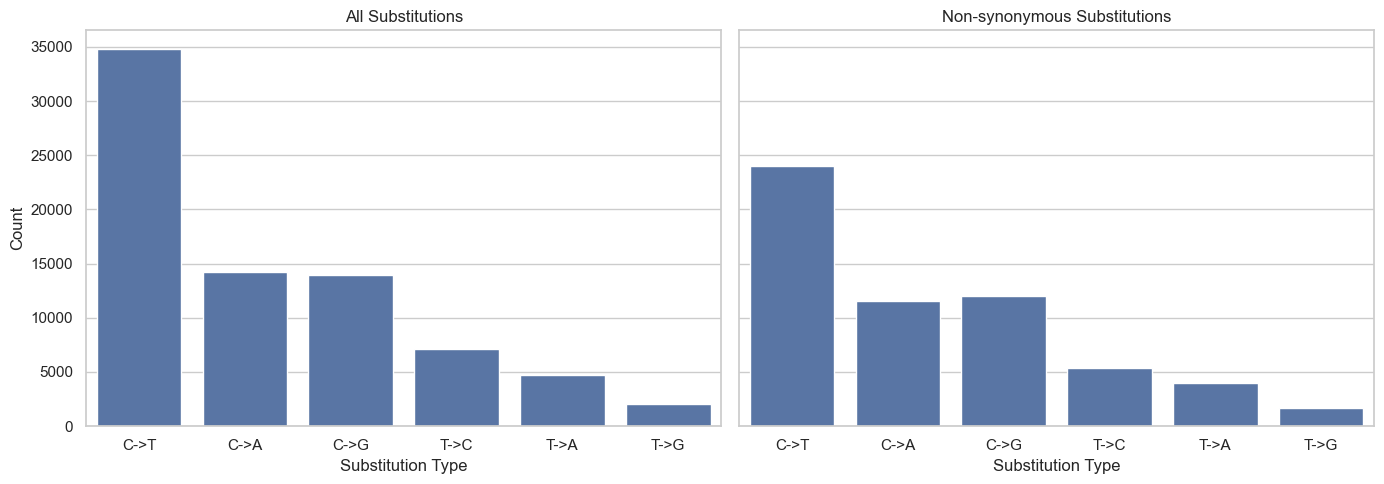

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: All substitutions
sns.countplot(ax=axes[0], x='_substitution', data=mutations,
              order=mutations['_substitution'].value_counts().index)
axes[0].set_title("All Substitutions")
axes[0].set_xlabel("Substitution Type")
axes[0].set_ylabel("Count")

# Plot 2: Non-synonymous substitutions
nonsyn = mutations[mutations['_dn_ds_mutation_type'] == 'nonsynonymous']
sns.countplot(ax=axes[1], x='_substitution', data=nonsyn,
              order=mutations['_substitution'].value_counts().index)
axes[1].set_title("Non-synonymous Substitutions")
axes[1].set_xlabel("Substitution Type")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


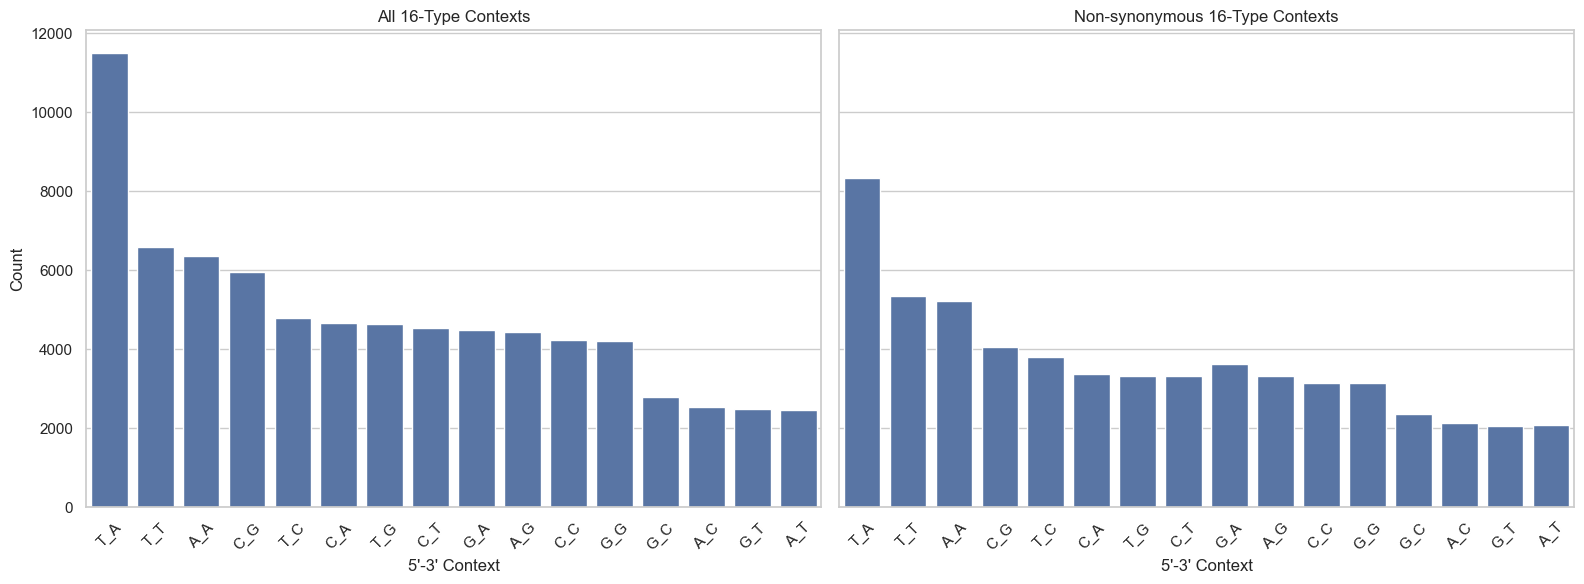

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: All 16-type contexts
sns.countplot(ax=axes[0], x='_16_type_context', data=mutations,
              order=mutations['_16_type_context'].value_counts().index)
axes[0].set_title("All 16-Type Contexts")
axes[0].set_xlabel("5'-3' Context")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Non-synonymous mutations only
nonsyn = mutations[mutations['_dn_ds_mutation_type'] == 'nonsynonymous']
sns.countplot(ax=axes[1], x='_16_type_context', data=nonsyn,
              order=mutations['_16_type_context'].value_counts().index)
axes[1].set_title("Non-synonymous 16-Type Contexts")
axes[1].set_xlabel("5'-3' Context")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [103]:
dN_dS = []

for gene in genes:
    subset = mutations[mutations.Hugo_Symbol == gene]
    n_dN = (subset['_dn_ds_mutation_type'] == 'nonsynonymous').sum()
    n_dS = (subset['_dn_ds_mutation_type'] == 'synonymous').sum()
    ratio = (n_dN + 1) / (n_dS + 1)  # add pseudocount
    dN_dS.append({'gene': gene, 'dN': n_dN, 'dS': n_dS, 'dN/dS': ratio})

# Convert to DataFrame
dnds_df = pd.DataFrame(dN_dS)


# Trinucleotide dn/ds

In [37]:
# 1. background model/probability 

# Count how many times each 96-class mutation occurs
count_df = mutations['_96_class'].value_counts().reset_index()
count_df.columns = ['_96_class', 'count']

# Split the _96_class into context and substitution
count_df[['_16_type_context', '_substitution']] = count_df['_96_class'].str.split('__', expand=True)

# Group by context and substitution, then sum counts
grouped = count_df.groupby(['_16_type_context', '_substitution'])['count'].sum().reset_index()

# Normalize within each context group to get mutation probabilities
grouped['mutation_rate'] = grouped.groupby('_16_type_context')['count'].transform(lambda x: x / x.sum())

# switch to dictionary 
mutation_rate_dict = {
    (row['_16_type_context'], row['_substitution']): row['mutation_rate']
    for _, row in grouped.iterrows()
}

In [64]:
genes = list(set(mutations.Hugo_Symbol.tolist()))
patients = list(set(mutations.patient_id.tolist()))
observed = []
expected = []

# testing
for gene in genes:
    # 2.1 Observed dN_dS
    mutation_per_gene = mutations[mutations.Hugo_Symbol == gene].copy()
    observed_dN_dS = dn_ds_ratio(mutation_per_gene)
    observed.append(observed_dN_dS)
    
    # 2.2 Expected dN_dS
    
    # i) get coding sequence and codon structure
    # Use Ensembl v75 (for GRCh37 / hg19)
    # data = EnsemblRelease(75)
    # data.download()
    # data.index()
    transcript_ids = data.transcript_ids_of_gene_name(gene)
    
    cds_seq = None
    for tid in transcript_ids:
        try:
            transcript = data.transcript_by_id(tid)
            cds_seq = transcript.coding_sequence
            break
        except ValueError:
            continue
    
    if cds_seq is None:
        #print(f"{gene}: No valid coding transcript found.")
        expected.append(float('nan'))
        continue
    
    # ii) simulate all possible point mutations 
    gene_results = pd.DataFrame(simulate_gene_mutations(cds_seq, mutation_rate_dict, codon_to_aa))
    
    # iii) calculate expected dN_dS
    nonsyn_sum = gene_results[gene_results['mutation_type'] == 'nonsynonymous']['mutation_probability'].sum()
    syn_sum = gene_results[gene_results['mutation_type'] == 'synonymous']['mutation_probability'].sum()
    
    expected_dN_dS = nonsyn_sum / syn_sum if syn_sum != 0 else float('inf')
    expected.append(expected_dN_dS)


In [65]:
dnds_df = pd.DataFrame({
    'gene': genes,
    'observed_dNdS': observed,
    'expected_dNdS': expected
}).set_index('gene')

In [67]:
dnds_df.to_csv("gene_dnds_trinucleotide_context_summary.csv")

In [69]:
dnds_df['ratio'] = dnds_df.observed_dNdS/dnds_df.expected_dNdS

In [73]:
dnds_df.sort_values(by='ratio',ascending=False).head(30)

,observed_dNdS,expected_dNdS,ratio
gene,,,
CDKN2A,82.000000,2.554473,32.100558
PIK3CA,82.000000,3.708402,22.111953
KMT2D,52.000000,2.653734,19.595028
CASP8,49.000000,2.679574,18.286487
HRAS,35.000000,2.082437,16.807229
NSD1,48.000000,3.319207,14.461287
EP300,34.000000,3.403238,9.990487
KEAP1,20.000000,2.192467,9.122143
TP53,24.307692,2.680771,9.067426


In [76]:
gene_results.head(30)

,codon_index,codon,mutated_codon,ref_base,alt_base,position_in_codon,context,substitution,mutation_type,mutation_probability
0,0,ATG,AAG,T,A,1,A_G,T->A,nonsynonymous,0.086859
1,0,ATG,ACG,T,C,1,A_G,T->C,nonsynonymous,0.142889
2,0,ATG,AGG,T,G,1,A_G,T->G,nonsynonymous,0.041629
3,0,ATG,ATA,G,A,2,T_T,C->T,nonsynonymous,0.334803
4,0,ATG,ATC,G,C,2,T_T,C->G,nonsynonymous,0.360803
5,0,ATG,ATT,G,T,2,T_T,C->A,nonsynonymous,0.157367
6,1,TAC,AAC,T,A,0,G_A,T->A,nonsynonymous,0.053970
7,1,TAC,CAC,T,C,0,G_A,T->C,nonsynonymous,0.077163
8,1,TAC,GAC,T,G,0,G_A,T->G,nonsynonymous,0.024755
9,1,TAC,TCC,A,C,1,T_C,T->G,nonsynonymous,0.022500


# Debug

In [ ]:
# 2.1 Observed dN_dS
mutation_per_gene = mutations[mutations.Hugo_Symbol == gene].copy()
observed_dN_dS = dn_ds_ratio(mutation_per_gene)

# 2.2 Expected dN_dS

# i) get coding sequence and codon structure
# Use Ensembl v75 (for GRCh37 / hg19)
# data = EnsemblRelease(75)
# data.download()
# data.index()
# Get transcript ID
transcript_id = data.transcript_ids_of_gene_name(gene)[0]
# Get the full Transcript object
transcript = data.transcript_by_id(transcript_id)
# Now get the CDS sequence
cds_seq = transcript.coding_sequence
# Optional: split into codons
codons = [cds_seq[i:i+3] for i in range(0, len(cds_seq), 3)]

# ii) simulate all possible point mutations 
gene_results = pd.DataFrame(simulate_gene_mutations(cds_seq, mutation_rate_dict, codon_to_aa))

# iii) calculate expected dN_dS
nonsyn_sum = gene_results[gene_results['mutation_type'] == 'nonsynonymous']['mutation_probability'].sum()
syn_sum = gene_results[gene_results['mutation_type'] == 'synonymous']['mutation_probability'].sum()

expected_dN_dS = nonsyn_sum / syn_sum if syn_sum != 0 else float('inf')